In [2]:
!pip install opencv-python-headless scipy h5py


In [3]:
from google.colab import files
uploaded = files.upload()


Saving crowd_wala_dataset.zip to crowd_wala_dataset.zip


In [4]:
import zipfile
import os

zip_path = next(iter(uploaded))  # gets uploaded filename
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("dataset")

# OPTIONAL: Check structure
!ls dataset/*


test_data  train_data


In [5]:
import cv2
import torch
import scipy.io
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.transforms.functional import to_tensor, normalize
from scipy.ndimage import gaussian_filter


In [6]:
def extract_points(mat):
    if 'annPoints' in mat:
        return mat['annPoints']
    elif 'image_info' in mat:
        points_raw = mat['image_info'][0, 0][0, 0][0]
        return np.array([[float(p[0]), float(p[1])] for p in points_raw])
    return np.empty((0, 2))

def generate_density_map(image_shape, points, sigma=15):
    h, w = image_shape
    density = np.zeros((h, w), dtype=np.float32)
    for point in points:
        x = min(w - 1, max(0, int(round(point[0]))))
        y = min(h - 1, max(0, int(round(point[1]))))
        density[y, x] += 1
    density = cv2.GaussianBlur(density, (0, 0), sigma)
    return density


In [7]:
class CrowdDataset(Dataset):
    def __init__(self, img_dir, gt_dir, transform=None, input_size=(384, 512), output_size=(48, 64)):
        self.img_dir = img_dir
        self.gt_dir = gt_dir
        self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg')])
        self.transform = transform
        self.input_size = input_size
        self.output_size = output_size

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        gt_path = os.path.join(self.gt_dir, 'GT_' + img_name.replace('.jpg', '.mat'))

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.input_size[1], self.input_size[0]))

        mat = scipy.io.loadmat(gt_path)
        points = extract_points(mat)

        density_map = generate_density_map(self.input_size, points, sigma=15)
        original_sum = density_map.sum()

        target_output_size = (64,48)  # (W, H) format for OpenCV
        density_map = cv2.resize(density_map, target_output_size, interpolation=cv2.INTER_CUBIC)

        if density_map.sum() > 0 and original_sum > 0:
            density_map *= (original_sum / density_map.sum())

        density_map = torch.from_numpy(density_map).unsqueeze(0).float()
        if self.transform:
            img = self.transform(img)
        else:
            img = torch.from_numpy(img.transpose((2, 0, 1))).float() / 255.0

        return img, density_map


In [8]:
class SFCN(nn.Module):
    def __init__(self):
        super(SFCN, self).__init__()
        self.features = models.vgg16_bn(weights=models.VGG16_BN_Weights.DEFAULT).features[:33]

        self.regressor = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.3),

            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 1, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.regressor(x)
        return x


In [9]:
!ls dataset


crowd_wala_dataset


In [10]:
!ls dataset/crowd_wala_dataset/train_data/images


IMG_100.jpg  IMG_161.jpg  IMG_221.jpg  IMG_282.jpg  IMG_342.jpg  IMG_41.jpg
IMG_101.jpg  IMG_162.jpg  IMG_222.jpg  IMG_283.jpg  IMG_343.jpg  IMG_42.jpg
IMG_102.jpg  IMG_163.jpg  IMG_223.jpg  IMG_284.jpg  IMG_344.jpg  IMG_43.jpg
IMG_103.jpg  IMG_164.jpg  IMG_224.jpg  IMG_285.jpg  IMG_345.jpg  IMG_44.jpg
IMG_104.jpg  IMG_165.jpg  IMG_225.jpg  IMG_286.jpg  IMG_346.jpg  IMG_45.jpg
IMG_105.jpg  IMG_166.jpg  IMG_226.jpg  IMG_287.jpg  IMG_347.jpg  IMG_46.jpg
IMG_106.jpg  IMG_167.jpg  IMG_227.jpg  IMG_288.jpg  IMG_348.jpg  IMG_47.jpg
IMG_107.jpg  IMG_168.jpg  IMG_228.jpg  IMG_289.jpg  IMG_349.jpg  IMG_48.jpg
IMG_108.jpg  IMG_169.jpg  IMG_229.jpg  IMG_28.jpg   IMG_34.jpg	 IMG_49.jpg
IMG_109.jpg  IMG_16.jpg   IMG_22.jpg   IMG_290.jpg  IMG_350.jpg  IMG_4.jpg
IMG_10.jpg   IMG_170.jpg  IMG_230.jpg  IMG_291.jpg  IMG_351.jpg  IMG_50.jpg
IMG_110.jpg  IMG_171.jpg  IMG_231.jpg  IMG_292.jpg  IMG_352.jpg  IMG_51.jpg
IMG_111.jpg  IMG_172.jpg  IMG_232.jpg  IMG_293.jpg  IMG_353.jpg  IMG_52.jpg
IMG_112.jpg  I

In [12]:
print("Pred:", preds.shape, "GT:", gts.shape)


NameError: name 'preds' is not defined

In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = CrowdDataset("dataset/crowd_wala_dataset/train_data/images", "dataset/crowd_wala_dataset/train_data/ground_truth", transform)
val_dataset = CrowdDataset("dataset/crowd_wala_dataset/test_data/images", "dataset/crowd_wala_dataset/test_data/ground_truth", transform)


train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SFCN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(1, 101):
    model.train()
    train_loss = 0.0
    for imgs, gts in train_loader:
        imgs, gts = imgs.to(device), gts.to(device)
        preds = model(imgs)
        loss = criterion(preds, gts)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    total_mae = 0.0
    with torch.no_grad():
        for imgs, gts in val_loader:
            imgs, gts = imgs.to(device), gts.to(device)
            preds = model(imgs)
            total_mae += torch.abs(preds.sum() - gts.sum()).item()

    print(f"Epoch {epoch}: Train Loss = {train_loss / len(train_loader):.4f}, Val MAE = {total_mae / len(val_loader):.2f}")


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:05<00:00, 107MB/s] 


Epoch 1: Train Loss = 0.0380, Val MAE = 98.80
Epoch 2: Train Loss = 0.0113, Val MAE = 84.78
Epoch 3: Train Loss = 0.0092, Val MAE = 127.17
Epoch 4: Train Loss = 0.0068, Val MAE = 242.53
Epoch 5: Train Loss = 0.0056, Val MAE = 172.44
Epoch 6: Train Loss = 0.0049, Val MAE = 112.38
Epoch 7: Train Loss = 0.0040, Val MAE = 67.12
Epoch 8: Train Loss = 0.0040, Val MAE = 107.94
Epoch 9: Train Loss = 0.0034, Val MAE = 198.35
Epoch 10: Train Loss = 0.0029, Val MAE = 90.25
Epoch 11: Train Loss = 0.0029, Val MAE = 110.86
Epoch 12: Train Loss = 0.0025, Val MAE = 104.46
Epoch 13: Train Loss = 0.0024, Val MAE = 143.10
Epoch 14: Train Loss = 0.0022, Val MAE = 72.45
Epoch 15: Train Loss = 0.0022, Val MAE = 144.23
Epoch 16: Train Loss = 0.0024, Val MAE = 145.01
Epoch 17: Train Loss = 0.0026, Val MAE = 111.29
Epoch 18: Train Loss = 0.0022, Val MAE = 178.99
Epoch 19: Train Loss = 0.0021, Val MAE = 145.41
Epoch 20: Train Loss = 0.0021, Val MAE = 90.47
Epoch 21: Train Loss = 0.0017, Val MAE = 81.77
Epoch 22

In [14]:
torch.save(model.state_dict(), "sfcn_crowd_count.pth")

from google.colab import files
files.download("sfcn_crowd_count.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
# Upload video
uploaded_video = files.upload()  # upload .mp4

video_path = next(iter(uploaded_video))
cap = cv2.VideoCapture(video_path)

# Output writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter("output_counted_video.mp4", fourcc, 10.0,
                      (int(cap.get(3)), int(cap.get(4))))

model.eval()
with torch.no_grad():
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        resized = cv2.resize(frame, (512, 384))
        rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
        tensor = to_tensor(rgb).unsqueeze(0).to(device)
        tensor = normalize(tensor[0], [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]).unsqueeze(0)

        pred = model(tensor)
        count = pred.sum().item()
        cv2.putText(frame, f"Count: {int(count)}", (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3)
        out.write(frame)

cap.release()
out.release()
print("Saved as output_counted_video.mp4")


Saving test.mp4 to test.mp4
Saved as output_counted_video.mp4


In [17]:
files.download("output_counted_video.mp4")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving sfcn_crowd_count.pth to sfcn_crowd_count (1).pth


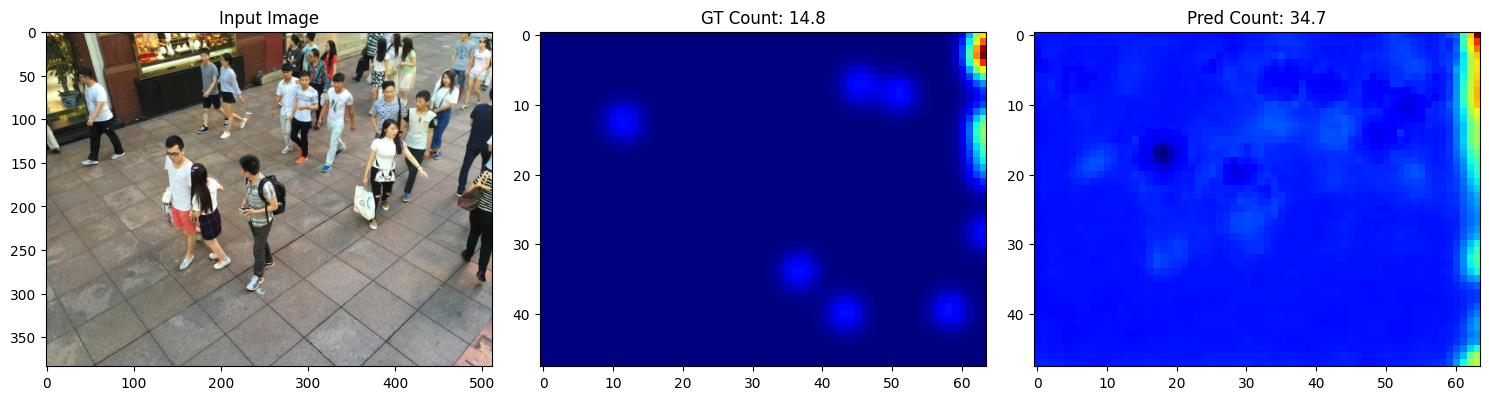

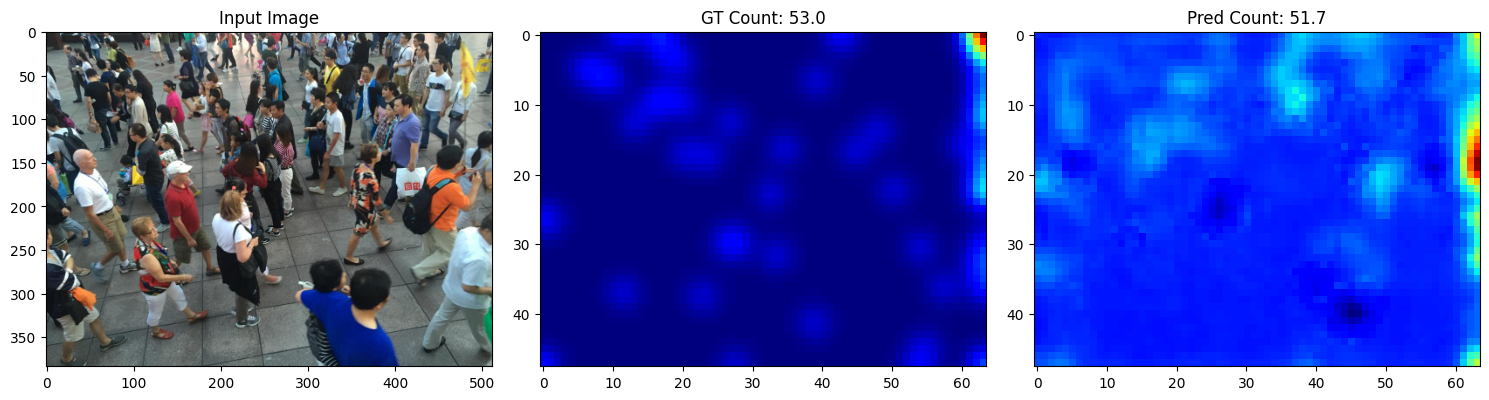

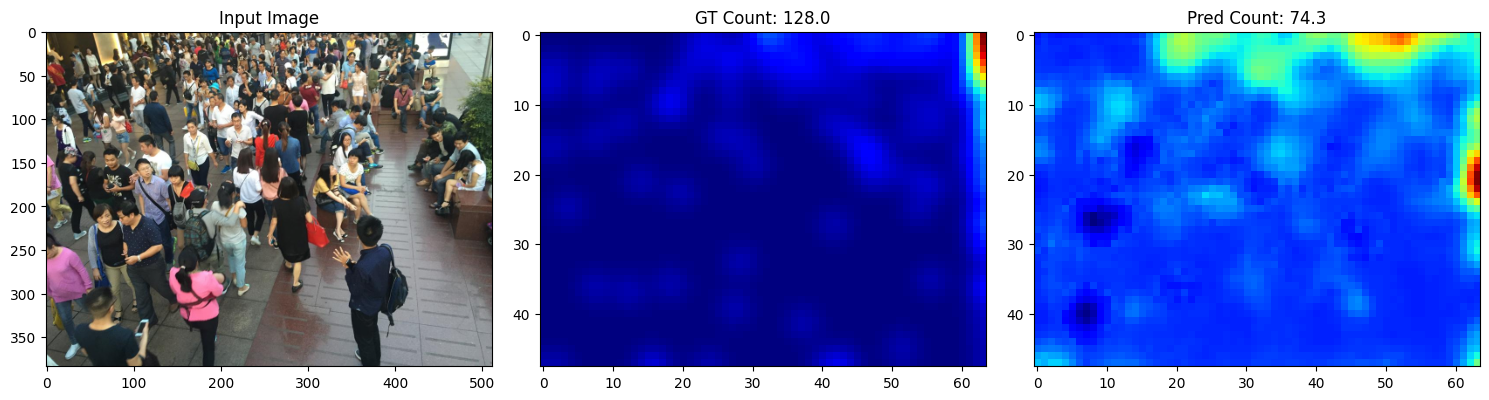

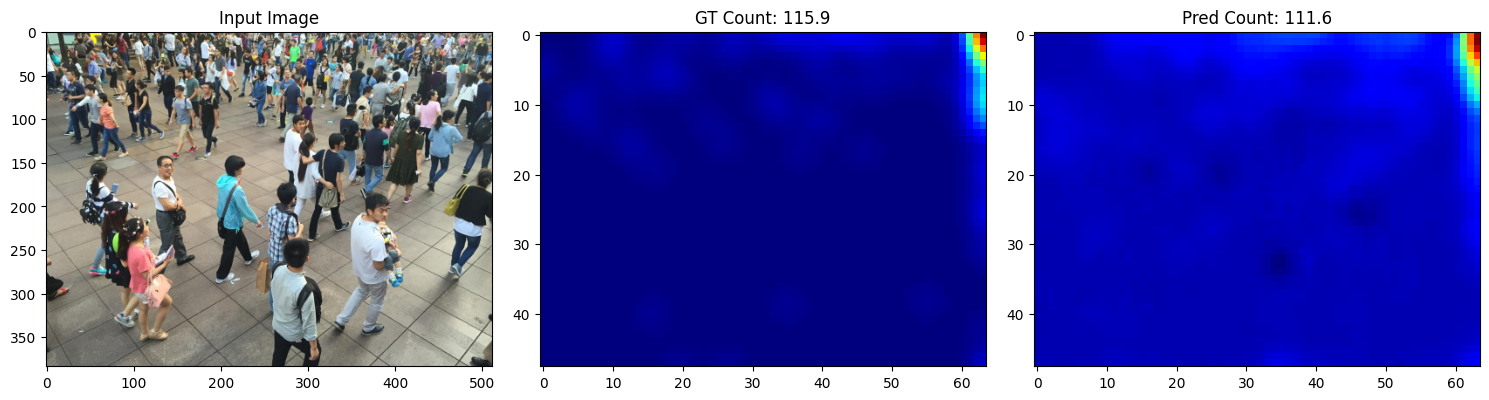

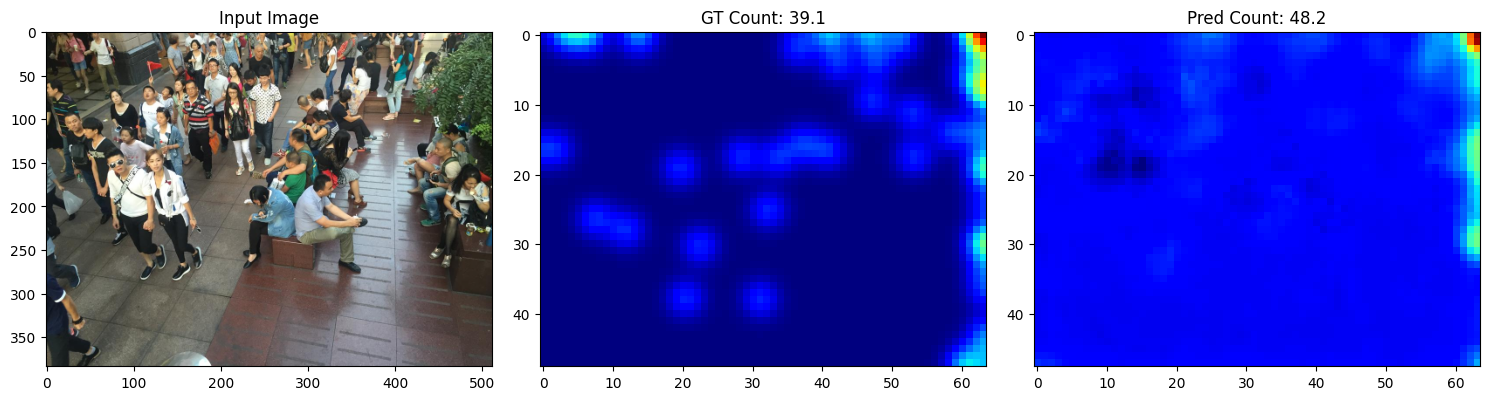

In [20]:
import matplotlib.pyplot as plt

from google.colab import files
uploaded = files.upload()  # Upload sfcn_crowd_count.pth

model = SFCN().to(device)
model.load_state_dict(torch.load("sfcn_crowd_count.pth", map_location=device))
model.eval()

num_images_to_show = 5  # Change this if you want more

with torch.no_grad():
    for idx, (img, gt_density) in enumerate(val_loader):
        if idx >= num_images_to_show:
            break

        img = img.to(device)
        gt_density = gt_density.to(device)

        pred_density = model(img)

        # Move everything to CPU and convert to numpy
        img_np = img[0].cpu().permute(1, 2, 0).numpy()
        img_np = (img_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # Denormalize
        img_np = np.clip(img_np, 0, 1)

        gt_map = gt_density[0][0].cpu().numpy()
        pred_map = pred_density[0][0].cpu().numpy()

        gt_count = gt_map.sum()
        pred_count = pred_map.sum()

        # Plotting
        plt.figure(figsize=(15, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(img_np)
        plt.title("Input Image")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_map, cmap='jet')
        plt.title(f"GT Count: {gt_count:.1f}")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_map, cmap='jet')
        plt.title(f"Pred Count: {pred_count:.1f}")

        plt.tight_layout()
        plt.show()


In [ ]:
from google.colab import files
import cv2
import torch
from torchvision.transforms.functional import to_tensor, normalize


print(" Upload your .mp4 video and .pth model file")
uploaded1 = files.upload()  # Upload both the video and sfcn_crowd_count.pth
uploaded2 = files.upload()
#  Identify paths
video_path = [f for f in uploaded1 if f.endswith('.mp4')][0]
model_path = [f for f in uploaded2 if f.endswith('.pth')][0]

#  Load model and weights
model = SFCN().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(" Loaded fine-tuned model from:", model_path)

#  Open video
cap = cv2.VideoCapture(video_path)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

#  Output writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter("output_counted_video.mp4", fourcc, fps, (frame_width, frame_height))

#  Inference loop
with torch.no_grad():
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        resized = cv2.resize(frame, (512, 384))
        rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
        tensor = to_tensor(rgb).to(device)
        tensor = normalize(tensor, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]).unsqueeze(0)

        pred = model(tensor)
        count = int(pred.sum().item())

        # Overlay count on original frame
        cv2.putText(frame, f"Count: {count}", (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3)
        out.write(frame)

cap.release()
out.release()
print("Saved as output_counted_video.mp4")


 Upload your .mp4 video and .pth model file
